In [1]:
import os, sys
sys.path.append('../')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch
import torchvision
import torchvision.transforms as transforms
from datasets.coco import CocoDataset
from utils.transforms import PhotometricDistort, Flip, Zoomout, \
                             ImageToTensor, CategoryToTensor, \
                             BoxToTensor, Resize, Normalize, \
                             CocoBoxToFracBoundaryBox, AssignObjToPbox
from functools import partial
import torch.nn as nn
import torch.nn.functional as F
from model.detector import SSD300
from loss.multibox import Loss
from torch.utils.tensorboard import SummaryWriter

DEVICE = 'cpu' if torch.cuda.device_count() == 0 else 'cuda:0'
print(DEVICE)

/Users/jcheng/opt/anaconda3/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


cpu


In [2]:
# initialize network 
N_CLASSES = 81
ssd = SSD300(n_classes=N_CLASSES, device=DEVICE)

In [3]:
# transforms
IMG_SZ = 300

distort_tfms  = [PhotometricDistort(0.5),
                 Flip(0.5)]
zoom_tfms     = [Zoomout(0.2, max_scale=2.5)]
toTensor_tfms = [ImageToTensor(), 
                 CategoryToTensor(), 
                 BoxToTensor()]
resize_tfms   = [Resize((IMG_SZ, IMG_SZ))]
target_tfms   = [CocoBoxToFracBoundaryBox(),
                 AssignObjToPbox(pboxes=ssd.pboxes, threshold=0.5)]
imgNorm_tfms  = [Normalize()]

tfms = transforms.Compose(distort_tfms + toTensor_tfms + zoom_tfms + imgNorm_tfms + resize_tfms + target_tfms)

# create dataset & dataloader
ds = CocoDataset('../datasets/', 'samples', 'instances', transforms=tfms)
assert ssd.n_classes == len(ds.id2cat.keys()), "# of class mismatch between dataset and ssd"
dl = torch.utils.data.DataLoader(ds, batch_size=4, shuffle=True, num_workers=2,
                                 collate_fn=partial(ds.collate_fn, img_resized=True))

# create tensorboard summary writer
writer = SummaryWriter('runs/vgg_base')

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [4]:
# loss function
loss = Loss(neg_pos_ratio=3, 
            alpha=1.,
            device=DEVICE)

In [5]:
# data object
class Data():
    def __init__(self, train_dl, valid_dl):
        self.train_dl = train_dl
        self.valid_dl = valid_dl

In [6]:
# create a data obj that wraps around train/valid dls
data = Data(train_dl=dl, valid_dl=dl)

In [7]:
# learner
class Learner():
    """
    Base learner class for all other learners to inherit from
    """
    def __init__(self, model, loss_func, metrics, data):
        self.model, self.loss_func, self.metrics, self.data = model, loss_func, metrics, data

learner = Learner(model=ssd, loss_func=loss, metrics=None, data=data)

In [8]:
# experiment class
from exp.supervised import SupervisedExp
from exp.callbacks.setup_callback import SetupCallback
from exp.callbacks.cocodatabatch_callback import CocoDataBatchCallback
from exp.callbacks.tensorboard_callback import TensorBoardCallback
exp = SupervisedExp(learner, cb_funcs=[CocoDataBatchCallback, TensorBoardCallback])

/Users/jcheng/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [9]:
# optimizer
EPOCHS = 10
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4

# init optimizer
opt = torch.optim.SGD(params=[{'params': exp.biases}, {'params': exp.weights}],
                      lr=1e-3, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Prediction

In [10]:
exp.load('../runs/1epochs.pth.tar', device=DEVICE)

checkpoint loaded; resume training from epoch 1.0


In [24]:
# transforms
IMG_SZ = 300

distort_tfms  = [PhotometricDistort(0.5),
                 Flip(0.5)]
zoom_tfms     = [Zoomout(0.2, max_scale=2.5)]
toTensor_tfms = [ImageToTensor(), 
                 CategoryToTensor(), 
                 BoxToTensor()]
resize_tfms   = [Resize((IMG_SZ, IMG_SZ))]
target_tfms   = [CocoBoxToFracBoundaryBox(),
                 AssignObjToPbox(pboxes=ssd.pboxes, threshold=0.5)]
imgNorm_tfms  = [Normalize()]

tfms = transforms.Compose(toTensor_tfms + resize_tfms + target_tfms + imgNorm_tfms)

# create dataset & dataloader
ds = CocoDataset('../datasets/', 'samples', 'instances', transforms=tfms)
assert ssd.n_classes == len(ds.id2cat.keys()), "# of class mismatch between dataset and ssd"
dl = torch.utils.data.DataLoader(ds, batch_size=4, shuffle=True, num_workers=2,
                                 collate_fn=partial(ds.collate_fn, img_resized=True))

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


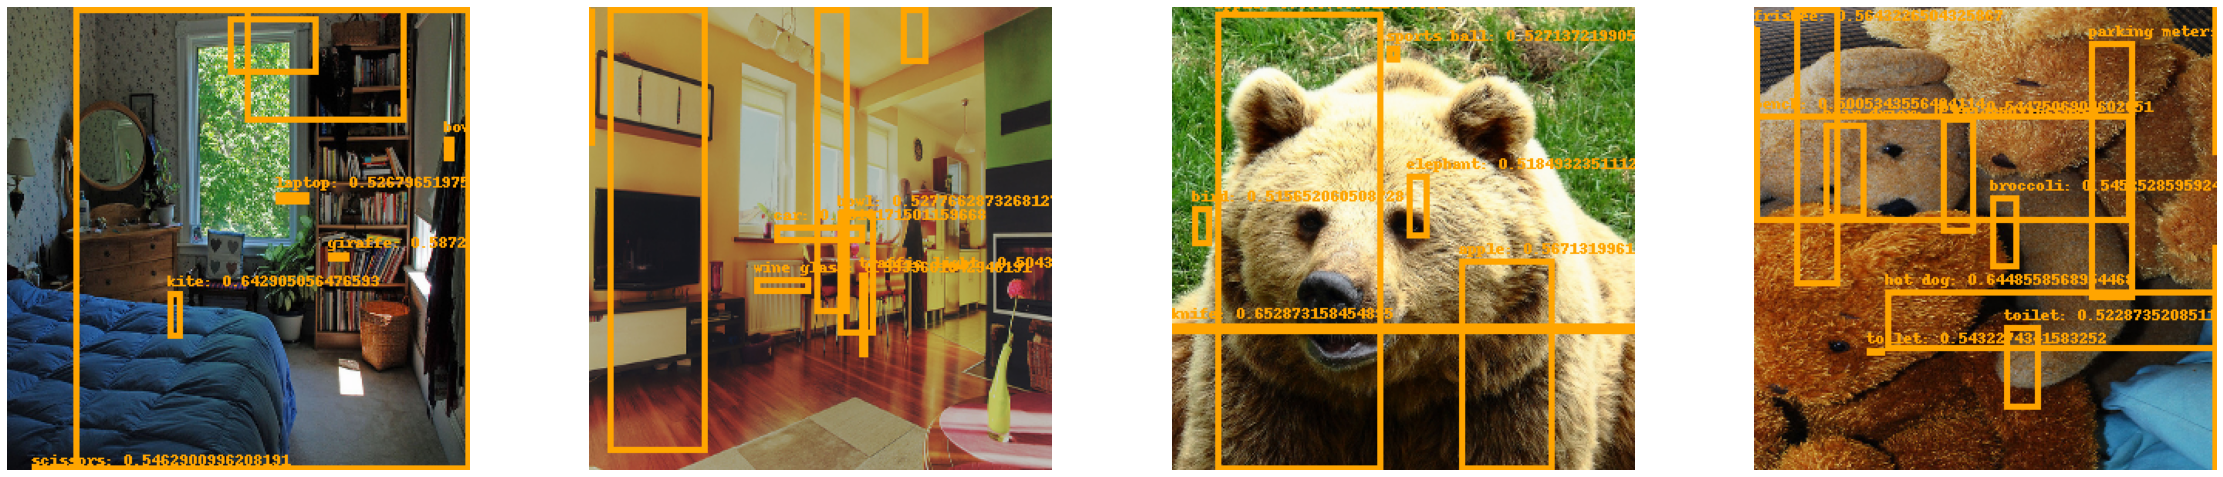

In [48]:
# import imageFont for drawing text
from PIL import ImageFont, ImageDraw
import matplotlib.pyplot as plt
import numpy as np


# get a batch of data
d_batch = next(iter(dl))
images, true_cats, true_boxes, img_dims = d_batch['images'], d_batch['cats'], d_batch['boxes'], d_batch['dims']


# inference
offsets_pred, cls_scores_pred = ssd(images.to(DEVICE))
detected_boxes, detected_labels, detected_scores = ssd.detect_objects( \
      offsets_pred, cls_scores_pred, \
      nms_threshold=0.3, \
      cls_score_threshold=0.5, \
      top_k=20 \
    )

# show prediction results
plt.figure(figsize=[40,80])
tf = transforms.ToPILImage()
normalize = Normalize()
for i, (boxes, dim) in enumerate(zip(detected_boxes, img_dims)):
    # get image
    image = images[i]    
    # de-normalize image
    normalize.decode(image)
    # convert to PIL image
    image = tf(image)
    plt.subplot(8,4,i+1)
    draw = ImageDraw.Draw(image, 'RGBA')
    # clamp bounding box coordinates btw [0,1]
    boxes = torch.clamp(boxes, min=0, max=1)
    for j in range(boxes.shape[0]):
        # draw bounding box
        draw.rectangle(boxes[j,:].detach().numpy()*300, outline='orange', width=4)
        # get object class name        
        obj_name = ds.id2cat[detected_labels[i].detach().numpy()[j]]
        # get object classificaiton score
        obh_score = detected_scores[i].detach().numpy()[j]
        # draw object label + score above the top-left corner of bounding box
        txt_coord = boxes[j,:2].detach().numpy()*300 + np.array([0,-12])
        text = f"{obj_name}: {obh_score}"
        draw.text(xy=(txt_coord[0], txt_coord[1]),
                  fill='orange',
#                   font=font,
                  text=text)
    plt.imshow(image); plt.axis('off')
    
    # # convert detected boxes back into original image coordinates
    # # in boundary coordinate format
    # coords = [bboxes[:,0]*dim[0], bboxes[:,1]*dim[1], bboxes[:,2]*dim[0], bboxes[:,3]*dim[1]]
    # bboxes = torch.cat([c.unsqueeze(-1) for c in coords], dim=-1)